# Example Workflow with spatialproteomics
Welcome to spatialproteomics! In this notebook, we will go through an example workflow by looking at the following steps:

1. Reading in a highly multiplexed image and creating a spatialproteomics object

2. Performing basic image processing steps to boost the signal-to-noise ratio

3. Performing cell segmentation using _cellpose_

4. Quantifying protein expression per cell

5. Predicting cell types with a simple argmax technique

6. Plotting the results

<p align="center" width="100%">
    <img src="../_static/img/figure_1.png" alt="Spatialproteomics orchestrates analysis workflows for highly multiplexed fluorescence images." style="width:50%;"/>
</p>

In [1]:
%load_ext autoreload
%autoreload 2

import spatialproteomics as sp
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d
import pandas as pd
import time

start_time = time.time()

## 1. Getting Started

Before we can get started with _spatialproteomics_, we first need to read in the image. This can be done with the _skimage_ or _tifffile_ libraries. If you want to follow along with this tutorial, you can download the data [here](https://oc.embl.de/index.php/s/XzEa9po1tjiDzzJ).

In [2]:
# reading in the image and displaying its shape
image = imread("../../data/input.tiff")
image.shape

(5, 500, 500)

We can see that our image has 5 channels and has a size of 500 by 500 pixels. Next, we want to create a _spatialproteomics_ object and store the image within the object. To do this, we also need to feed in the names of the channels.

In [3]:
sp_object = sp.load_image_data(image, channel_coords=["DAPI", "CD4", "CD8", "FOXP3", "BCL6"])

Instead of manually typing out all channels in the form of a list, you can also simply read it in from a file, and then provide the resulting list to spatialproteomics.

In [4]:
markers = pd.read_csv("../../data/markerlist.txt", header=None)[0].tolist()
markers

['DAPI', 'CD4', 'CD8', 'FOXP3', 'BCL6']

In [5]:
# loading the markers into the object
sp_object = sp.load_image_data(image, channel_coords=markers)

`sp.load_image_data()` returns an xarray object that we can simply inspect by calling in an jupyter cell. Note that the image is stored as the data variable `_image`.

In [6]:
sp_object

<xarray.Dataset> Size: 3MB
Dimensions:   (channels: 5, y: 500, x: 500)
Coordinates:
  * channels  (channels) <U5 100B 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y         (y) int64 4kB 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x         (x) int64 4kB 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    _image    (channels, y, x) uint16 2MB 10816 12359 14504 10965 ... 129 149 59

## 2. Image Processing
Highly multiplexed fluorescence imaging techniques frequently suffer from poor signal-to-noise ratio. To alleviate this problem, you can threshold out low intensity pixels, thereby boosting the contrast of the image. While there are automated methods to determine the thresholds for such operations, it is difficult to come up with one that works in all cases. Here, we therefore set the thresholds based on manual inspection. For more details, check the notebook on `Image Processing`.

Let's start by looking at the data set in the current form.

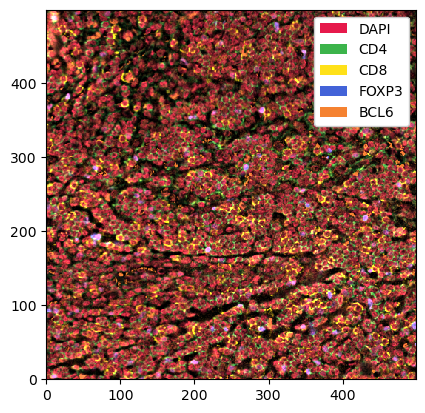

In [7]:
_ = sp_object.pl.show()  # pl: the plotting module

This is a bit much to look at. First, we want to check only the DAPI channel, to get a feel for the signal-to-noise ratio.

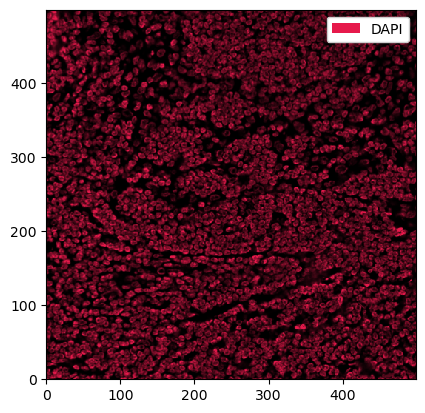

In [8]:
_ = sp_object.pp["DAPI"].pl.show()  # we can use pp[channels] to subset the spatialproteomics object

This looks promising. What about the other channels?

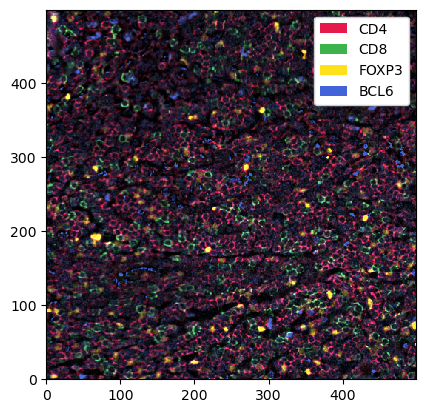

In [9]:
_ = sp_object.pp[["CD4", "CD8", "FOXP3", "BCL6"]].pl.show()  # pp: the preprocessing module

Looking good, but we can make the signal a bit clearer by performing some image processing. In the following codeblock, we first threshold the channels by some percentile (so every value below that percentile gets set to 0). We then apply a 2D median filter with a kernel size of 3 to apply some smoothing.

In [10]:
# the percentiles by which the channels will be thresholded
percentiles = [0.2, 0.6, 0.6, 0.6, 0.6]

# thresholding and smoothing the data
sp_object = sp_object.pp.threshold(percentiles).pp.apply(medfilt2d, kernel_size=3)

Let's plot the new object.

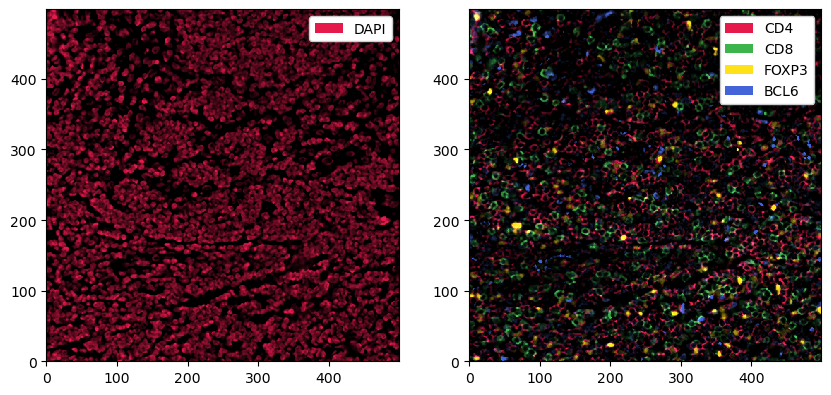

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = sp_object.pp["DAPI"].pl.show(ax=ax[0])
_ = sp_object.pp[["CD4", "CD8", "FOXP3", "BCL6"]].pl.show(ax=ax[1])

## 3. Cell Segmentation

Great, this is our preprocessing done. Next, we can perform cell segmentation. Since we only have a universal nuclear marker at hand (and no universal membrane marker), we will segment the nuclei and then simply extend the segmentation masks by two pixels in every direction. We are going to use _cellpose_ for this purpose, which is implemented in the tool (tl) module. Note that this requires you to install cellpose first, for example by running `pip install cellpose` in your terminal.

In [12]:
sp_object = sp_object.tl.cellpose(channel="DAPI")



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.10.0 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




** TORCH CUDA version installed and working. **
>>>> using GPU (CUDA)
>>>> loading model /home/meyerben/.cellpose/models/cpsam


Looking at the object, you will realize that a new layer called `_segmentation` has appeared. This layer can be used for downstream analysis and visualization.

In [13]:
sp_object

<xarray.Dataset> Size: 3MB
Dimensions:        (channels: 5, y: 500, x: 500, cells: 2267, features: 2)
Coordinates:
  * channels       (channels) <U5 100B 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y              (y) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * cells          (cells) int64 18kB 1 2 3 4 5 6 ... 2263 2264 2265 2266 2267
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint16 2MB 0 9602 9690 5351 4892 ... 0 0 0 0
    _segmentation  (y, x) uint16 500kB 0 1 1 1 1 1 0 2 2 2 ... 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 36kB 2.743 2.771 ... 497.9 149.0

We can plot this segmentation over the DAPI channel to see what exactly _cellpose_ did. We can zoom in a little bit to get a clearer picture.

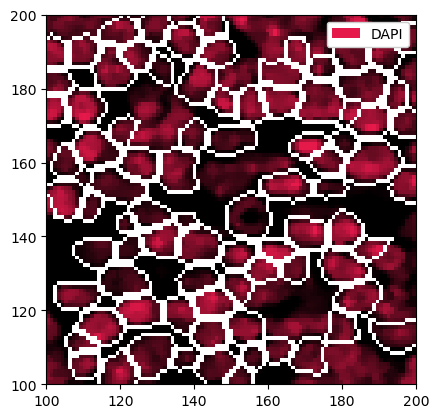

In [14]:
_ = sp_object.pp["DAPI"].pp[100:200, 100:200].pl.show(render_segmentation=True)

There are two issues with the current masks. One is that sometimes very small cells get segmented, which are likely artifacts. We can hence filter cells that are too small or too big. In addition, we will grow the masks by two pixels in each direction to try to capture cytoplasm and membrane. Note that with cellpose-sam, the masks sometimes already capture more of the area surrounding the nucleus, making the mask growing step optional.

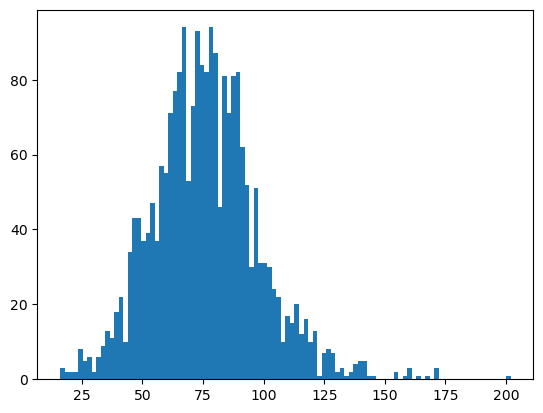

In [15]:
# checking the distribution of cell sizes
sp_object = sp_object.pp.add_observations("area")
df = sp_object.pp.get_layer_as_df("_obs")
_ = plt.hist(df["area"], bins=100)

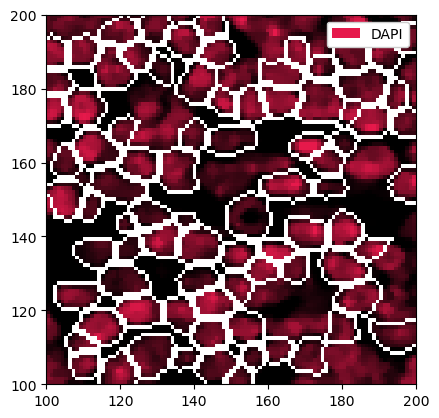

In [16]:
# filtering out cells with less than 20 or more than 150 pixels
sp_object = sp_object.pp.filter_by_obs("area", func=lambda x: (x > 20) & (x < 150))
# plotting the result
_ = sp_object.pp["DAPI"].pp[100:200, 100:200].pl.show(render_segmentation=True)

In [17]:
# expanding the masks
sp_object = sp_object.pp.grow_cells(iterations=2)

Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


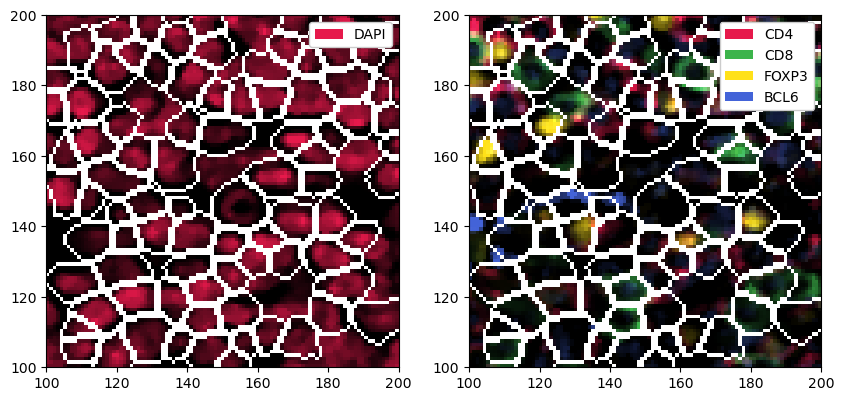

In [18]:
# plotting the resulting segmentation masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = sp_object.pp["DAPI"].pp[100:200, 100:200].pl.show(render_segmentation=True, ax=ax[0])
_ = sp_object.pp[["CD4", "CD8", "FOXP3", "BCL6"]].pp[100:200, 100:200].pl.show(render_segmentation=True, ax=ax[1])

## 4. Quantifying Protein Expression per Cell
Now that we have sensible segmentation masks, we can quantify the protein expression in each cell. There are multiple ways to do this, but taking the median intensity and then applying an arcsinh-transform has been proven to work pretty well.

In [19]:
sp_object = sp_object.pp.add_quantification(func="intensity_mean").pp.transform_expression_matrix(method="arcsinh")
sp_object

<xarray.Dataset> Size: 3MB
Dimensions:        (channels: 5, y: 500, x: 500, cells: 2249, features: 2)
Coordinates:
  * channels       (channels) <U5 100B 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y              (y) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * x              (x) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * cells          (cells) int64 18kB 1 2 3 4 5 6 ... 2245 2246 2247 2248 2249
  * features       (features) <U10 80B 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) uint16 2MB 0 9602 9690 5351 4892 ... 0 0 0 0
    _segmentation  (y, x) uint16 500kB 1 1 1 1 1 1 1 2 2 2 ... 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 36kB 2.615 2.641 ... 495.9 261.6
    _intensity     (cells, channels) float64 90kB 7.84 4.588 ... 0.8559 1.653

As you can see, this introduced a new layer called `_intensity`. We can now use this to predict cell types.

## 5. Cell Type Prediction
There are several ways to predict cell types. Since we thresholded our data beforehand, we can simply take the argmax of the cell type specific channels to get an idea of the cell types we are looking at. Methods related to cell type prediction are all implemented in the label (la) module.

In [20]:
# this dictionary maps from cell types to markers
marker_dict = {"CD4": "T_h", "CD8": "T_tox", "FOXP3": "T_reg", "BCL6": "T_fh"}
sp_object = sp_object.la.predict_cell_types_argmax(marker_dict)

In [21]:
sp_object

<xarray.Dataset> Size: 3MB
Dimensions:         (labels: 4, la_props: 2, channels: 5, y: 500, x: 500,
                     cells: 2249, features: 3)
Coordinates:
  * labels          (labels) int64 32B 1 2 3 4
  * la_props        (la_props) <U6 48B '_color' '_name'
  * channels        (channels) <U5 100B 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y               (y) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * x               (x) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * cells           (cells) int64 18kB 1 2 3 4 5 6 ... 2245 2246 2247 2248 2249
  * features        (features) <U10 120B '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _la_properties  (labels, la_props) object 64B '#000035' 'T_fh' ... 'T_tox'
    _image          (channels, y, x) uint16 2MB 0 9602 9690 5351 ... 0 0 0 0
    _segmentation   (y, x) uint16 500kB 1 1 1 1 1 1 1 2 2 ... 0 0 0 0 0 0 0 0 0
    _obs            (cells, features) float64 54kB 4.0 2.615 ... 495.9 261.6
    _intensity      (cells, channels) float64 90kB 7.84 4.588 ... 0.8559 1.653

This added a couple of things. For one, `_obs` now contains a feature called `_labels`. Furthermore, the `_la_properties` layer assigns each cell type to a color, which can be useful for plotting.

## 6. Plotting
Finally, let's do some plotting of the predicted cell types next to the markers. Before plotting, we can set some colors for the cell types (labels).

In [22]:
# setting the colors for the cell types
sp_object = sp_object.la.set_label_colors(["T_h", "T_tox", "T_reg", "T_fh"], ["red", "green", "yellow", "blue"])

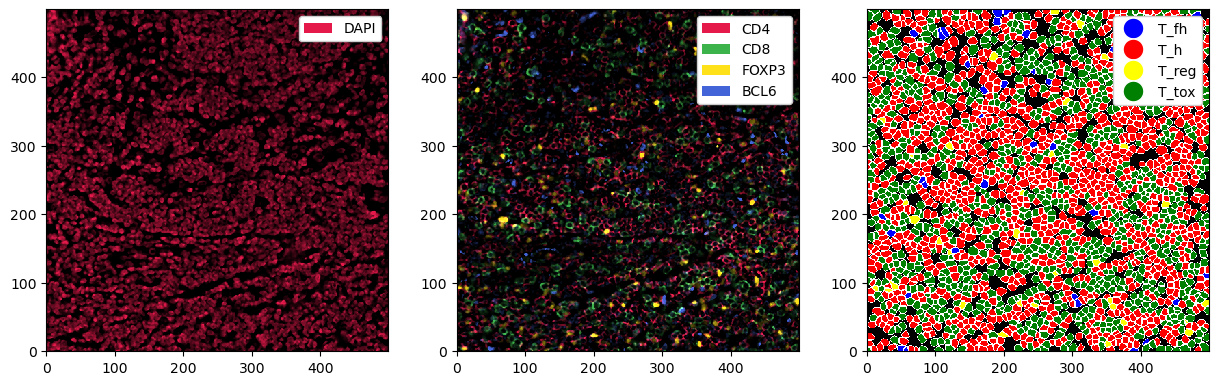

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
_ = sp_object.pp["DAPI"].pl.show(ax=ax[0])
_ = sp_object.pp[["CD4", "CD8", "FOXP3", "BCL6"]].pl.show(ax=ax[1])
_ = sp_object.pl.show(render_image=False, render_segmentation=True, render_labels=True, ax=ax[2])

And this is how easy it can be to perform analysis of highly multiplexed immunofluorescence images! If you have any additional questions, check out the other notebooks for details.

## Session Info

In [24]:
import time
import psutil
import subprocess

# Time
end_time = time.time()
runtime_seconds = end_time - start_time
print(f"Runtime: {runtime_seconds:.2f} seconds")

# Memory
process = psutil.Process()
mem_info = process.memory_info()
rss_in_mb = mem_info.rss / 1024**2
print(f"Memory used (RSS): {rss_in_mb:.2f} MB")

# GPU
try:
    gpu_info = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=memory.used,memory.total", "--format=csv,nounits,noheader"], encoding="utf-8"
    )
    used, total = map(int, gpu_info.strip().split(","))
    print(f"GPU memory used: {used} MB / {total} MB")
except Exception as e:
    print("GPU info not available:", e)

Runtime: 83.45 seconds
Memory used (RSS): 2410.40 MB
GPU memory used: 4874 MB / 11264 MB
